In [2]:
# dependencies
import tweepy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import time
import os
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from config import consumer_key, consumer_secret, access_token, access_token_secret
analyzer = SentimentIntensityAnalyzer()

In [3]:
# set up tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [4]:
# list of news sources
outlets = ["@BBCNews", "@CBSNews", "@CNN", "@FoxNews", "@nytimes"]

In [6]:
# Initialize empty lists for dataframe
source_name = []
screen_name = []
tweet_text = []
tweet_date = []
compound = []
positive = []
neutral = []
negative = []
tweets_ago = []
# Loop through each news source
for outlet in outlets:
    # initialize counter as 0
    counter = 0
    # Loop through the news source's tweets
    for status in tweepy.Cursor(api.user_timeline, id=outlet, tweet_mode='extended').items(100):
        # Put tweets ago and tweet source into their lists
        tweet = status._json
        tweets_ago.append(counter)
        screen_name.append(outlet)
        source_name.append(tweet['user']['name'])
        # Get text of tweet, put into list
        full_text = tweet['full_text']
        tweet_text.append(full_text)
        # Convert created date into datetime object, put into list
        raw_date = tweet['created_at']
        tweet_date.append(datetime.strptime(raw_date, "%a %b %d %H:%M:%S %z %Y"))
        # Do sentiment analysis, put each sentiment value into their list
        analyzer_result = analyzer.polarity_scores(full_text)
        compound.append(analyzer_result['compound'])
        positive.append(analyzer_result['pos'])
        neutral.append(analyzer_result['neu'])
        negative.append(analyzer_result['neg'])
        # Increment counter
        counter += 1
analysis_timestamp = datetime.now()
analysis_timestamp_string = datetime.strftime(analysis_timestamp, "%a %b %d %H:%M:%S %z %Y")
print(f"Analysis done on (datetime object) {analysis_timestamp}")
print(f"Analysis done on (string) {analysis_timestamp_string}")

Analysis done on (datetime object) 2018-04-08 23:17:22.129854
Analysis done on (string) Sun Apr 08 23:17:22  2018


In [7]:
# Put lists together into main dataframe, save as csv
tweet_data = {"News Outlet":source_name, "Screenname":screen_name, "Tweets Ago":tweets_ago, "Status":tweet_text, "Date":tweet_date,
              "Compound Score":compound, "Positive Score":positive, "Neutral Score":neutral, "Negative Score":negative}
main_df = pd.DataFrame(tweet_data)
main_df.to_csv(path_or_buf="news_outlet_sentiment.csv")

In [8]:
# Make dataframe for each
def filter_df(screenname):
    new_df = main_df.loc[main_df["Screenname"]==screenname, :]
    return new_df
bbc_df = filter_df(outlets[0])
cbs_df = filter_df(outlets[1])
cnn_df = filter_df(outlets[2])
fox_df = filter_df(outlets[3])
nyt_df = filter_df(outlets[4])
df_dictionary = {outlets[0]:bbc_df, outlets[1]:cbs_df, outlets[2]:cnn_df, outlets[3]:fox_df, outlets[4]:nyt_df}

In [53]:
# find average compound scores for each, put into averages dataframe
avg_compound_list = []
stn_dev_list = []
for df in df_dictionary.values():
    avg_compound = np.mean(df["Compound Score"])
    avg_compound_list.append(avg_compound)
    stn_dev = np.std(df["Compound Score"])
    stn_dev_list.append(stn_dev)
avg_data = {"Name":["BBC", "CBS", "CNN", "Fox", "NYT"], "Avg Compound Score":avg_compound_list, "Standard Deviation":stn_dev_list}
avg_df = pd.DataFrame(avg_data)
avg_df = avg_df.set_index("Name")
avg_df

,Avg Compound Score,Standard Deviation
Name,,
BBC,-0.011905,0.498686
CBS,-0.234276,0.423756
CNN,-0.109810,0.428045
Fox,-0.038434,0.475411
NYT,0.001131,0.464568


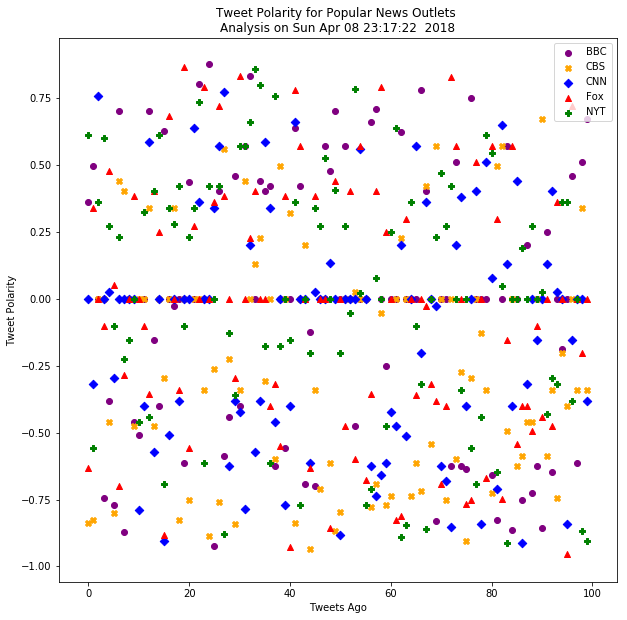

In [41]:
# Build scatter plots for each outlet based on tweets ago
plt.figure(figsize = (10,10))
bbc_plot = plt.scatter(bbc_df["Tweets Ago"], bbc_df["Compound Score"], marker = 'o', color = 'purple')
cbs_plot = plt.scatter(cbs_df["Tweets Ago"], cbs_df["Compound Score"], marker = 'X', color = 'orange')
cnn_plot = plt.scatter(cnn_df["Tweets Ago"], cnn_df["Compound Score"], marker = 'D', color = 'blue')
fox_plot = plt.scatter(fox_df["Tweets Ago"], fox_df["Compound Score"], marker = '^', color = 'red')
nyt_plot = plt.scatter(nyt_df["Tweets Ago"], nyt_df["Compound Score"], marker = 'P', color = 'green')
plt.legend((bbc_plot, cbs_plot, cnn_plot, fox_plot, nyt_plot), ("BBC", "CBS", "CNN", "Fox", "NYT"),
           loc = 'upper right')
plt.xlabel("Tweets Ago")
plt.ylabel("Tweet Polarity")
plt.title(f"Tweet Polarity for Popular News Outlets \nAnalysis on {analysis_timestamp_string}")
plt.savefig("tweet_polarity_scatter.png")
plt.show()

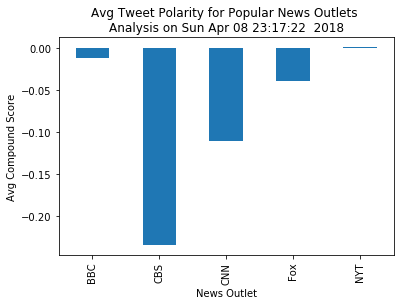

In [54]:
# Build bar chart for average compound score of each outlet
avg_df["Avg Compound Score"].plot(kind = 'bar')
plt.xlabel("News Outlet")
plt.ylabel("Avg Compound Score")
plt.title(f"Avg Tweet Polarity for Popular News Outlets \nAnalysis on {analysis_timestamp_string}")
plt.savefig("avg_tweet_polarity_bar.png")
plt.show()

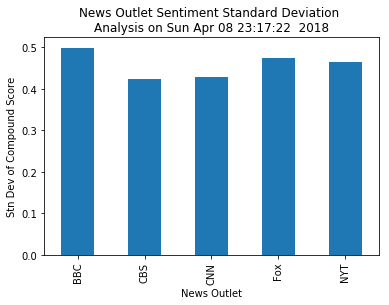

In [55]:
# Build bar chart for standard deviation of each outlet
avg_df["Standard Deviation"].plot(kind = 'bar')
plt.xlabel("News Outlet")
plt.ylabel("Stn Dev of Compound Score")
plt.title(f"News Outlet Sentiment Standard Deviation \nAnalysis on {analysis_timestamp_string}")
plt.savefig("stn_dev_bar.png")
plt.show()